<a href="https://colab.research.google.com/github/android-kunjapppan/GAN/blob/master/FCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LeakyReLU


from keras.layers import Input

from keras.datasets import mnist



In [61]:

np.random.seed(10)

noise_dim = 100

batch_size = 16
steps_per_epoch = 3750
epochs = 10

save_path = 'fcgan-img'

img_rows, img_cols, channels = 28,28,1

optimizer = Adam(0.0002, 0.5)

In [62]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = (x_train.astype(np.float32)-127.5)/127.5

x_train = x_train.reshape(-1,img_rows*img_cols*channels)

if not os.path.isdir(save_path):
  os.mkdir(save_path)



In [63]:
def generator():
  generator =Sequential([
                   Dense(128,input_dim=noise_dim),
                   LeakyReLU(0.2),

                   Dense(512),
                   LeakyReLU(0.2),

                   Dense(1024),
                   LeakyReLU(0.2),

                   Dense(img_rows*img_cols*channels,activation='tanh'),
                  ])
  
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

In [64]:
def discriminator():
  discriminator=Sequential([
                          Dense(1024,input_dim=img_rows*img_cols*channels),
                          LeakyReLU(0.2),

                          Dense(512),
                          LeakyReLU(0.2),

                          Dense(256),
                          LeakyReLU(0.2),

                          Dense(1,activation='sigmoid')
                          ])

  discriminator.compile(loss='binary_crossentropy',optimizer=optimizer)

  return discriminator

In [65]:
Discriminator = discriminator()
Generator= generator()

In [66]:
Discriminator.trainable=False

input = Input(shape = (noise_dim ,))
fake_img = Generator(input)

output = Discriminator(fake_img)

gan = Model(input,output)
gan.compile(loss='binary_crossentropy',optimizer=optimizer)


In [67]:
def show_img(noise, epoch = None):
  generated_img = Generator.predict(noise)
  plt.figure(figsize=(10,10))
  for i, img in enumerate(generated_img):
    plt.subplot(10,10,i+1)
    if channels==1:
      plt.imshow(img.reshape((img_rows,img_cols)),cmap='gray')
    else:
      plt.imshow(img.reshape((img_rows,img_cols,channels)))
    plt.axis('off')
  
  plt.tight_layout()

  if epoch!=None and save_path!=None:
    plt.savefig(f'{save_path}/gan-image_epoch-{epoch}.png')
  
  plt.show()

0 	 Discriminator Loss: 0.5061891078948975 		 Generator Loss: 1.6197129487991333


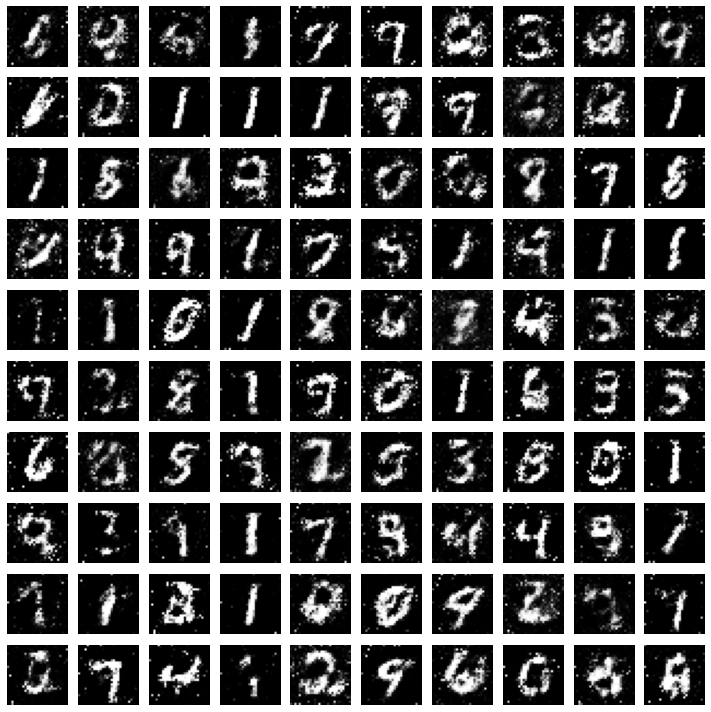

1 	 Discriminator Loss: 0.5764988660812378 		 Generator Loss: 1.3475337028503418
2 	 Discriminator Loss: 0.528942346572876 		 Generator Loss: 1.8111892938613892
3 	 Discriminator Loss: 0.603693962097168 		 Generator Loss: 1.3877193927764893
4 	 Discriminator Loss: 0.5564574599266052 		 Generator Loss: 1.5262303352355957
5 	 Discriminator Loss: 0.4629368185997009 		 Generator Loss: 1.7979373931884766
6 	 Discriminator Loss: 0.6285308003425598 		 Generator Loss: 1.473085641860962
7 	 Discriminator Loss: 0.5298172831535339 		 Generator Loss: 1.7703027725219727
8 	 Discriminator Loss: 0.531217634677887 		 Generator Loss: 1.5505355596542358
9 	 Discriminator Loss: 0.5048313140869141 		 Generator Loss: 1.57834792137146


In [68]:
static_noise= np.random.normal(0,1,size=(100,noise_dim))

for epoch in range(epochs):
  for batch in range(steps_per_epoch):
    noise = np.random.normal(0,1,size=(batch_size,noise_dim))
    fake_x= Generator.predict(noise)

    real_x= x_train[np.random.randint(0,x_train.shape[0],size=batch_size)]

    x=np.concatenate((real_x,fake_x))

    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size]=0.9

    d_loss = Discriminator.train_on_batch(x,disc_y)

    y_gen = np.ones(batch_size)
    g_loss= gan.train_on_batch(noise,y_gen)
  
  print(f'{epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

  if epoch % 10 ==0:
    show_img(static_noise,epoch)




In [71]:
# Turn the training process into a GIF
from PIL import Image, ImageDraw

image_names = os.listdir(save_path)

frames = []
for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
    frames.append(Image.open(save_path + '/' + image))

frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=80, loop=0)

Discriminator.save('fcdiscriminator.h5')
Generator.save('fcgenerator.h5')